## Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import ConcreteModel, Var, NonNegativeReals, Objective, Constraint, minimize, SolverFactory, value, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints

import warnings
warnings.filterwarnings('ignore')

## Directory

In [2]:
homepath = "C:/A.PROJECTS/stockprediction/"

## Data

In [3]:
stock_prices = pd.read_csv(homepath + 'data/stock_prices_30_tickers.csv',parse_dates=['Date'], index_col='Date')

In [4]:
def compute_returns(df):
    """
    Computes weekly, monthly, quarterly, and annual simple and log returns
    from a DataFrame of daily adjusted prices.

    Args:
        df (pd.DataFrame): DataFrame with daily adjusted prices. The index should be datetime.

    Returns:
        dict: A dictionary containing DataFrames for weekly, monthly, quarterly, and annual simple and log returns.
    """

    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Function to calculate simple returns
    def calculate_simple_returns(data):
        return data.pct_change().dropna()

    # Function to calculate log returns
    def calculate_log_returns(data):
        return np.log(data).diff().dropna()

    # Resample data and calculate simple returns
    weekly_simple_returns = calculate_simple_returns(df.resample('W').last())
    monthly_simple_returns = calculate_simple_returns(df.resample('M').last())
    quarterly_simple_returns = calculate_simple_returns(df.resample('Q').last())
    annual_simple_returns = calculate_simple_returns(df.resample('Y').last())

    # Resample data and calculate log returns
    weekly_log_returns = calculate_log_returns(df.resample('W').last())
    monthly_log_returns = calculate_log_returns(df.resample('M').last())
    quarterly_log_returns = calculate_log_returns(df.resample('Q').last())
    annual_log_returns = calculate_log_returns(df.resample('Y').last())

    return {
        'weekly_simple': weekly_simple_returns,
        'monthly_simple': monthly_simple_returns,
        'quarterly_simple': quarterly_simple_returns,
        'annual_simple': annual_simple_returns,
        'weekly_log': weekly_log_returns,
        'monthly_log': monthly_log_returns,
        'quarterly_log': quarterly_log_returns,
        'annual_log': annual_log_returns
    }

In [5]:
rets = compute_returns(stock_prices)

## Optimization

### Efficient Frontier

In [6]:
def optimize_portfolio(returns_df, target_return, solver='ipopt'):
    mean_returns = returns_df.mean().values
    cov_matrix = returns_df.cov().values
    num_assets = len(mean_returns)

    # Model Definition
    model = ConcreteModel()
    
    # Decisoin Variable
    model.weights = Var(range(num_assets), domain=NonNegativeReals, initialize=1/num_assets)
    
    # Objective: Minimize Portfolio Variance
    model.portfolio_variance = sum(
        model.weights[i] * model.weights[j] * cov_matrix[i, j]
        for i in range(num_assets) for j in range(num_assets)
    )
    model.objective = Objective(expr=model.portfolio_variance, sense=minimize)

    # Constraints
    model.expected_return = sum(model.weights[i] * mean_returns[i] for i in range(num_assets))
    model.constraints = Constraint(expr=sum(model.weights[i] for i in range(num_assets)) == 1)  # Sum of weights = 1
    model.return_constraint = Constraint(expr=model.expected_return == target_return)  # Target Return Constraint

    # Solve the Model
    opt = SolverFactory(solver)
    results = opt.solve(model, tee=False)

    # Check for infeasibility
    if results.solver.termination_condition != TerminationCondition.optimal:
        print(f"Target return {target_return} infeasible.")
        log_infeasible_constraints(model)
        return None, None  # Return None for weights and variance if infeasible

    # Extract Results
    weights = [value(model.weights[i]) for i in range(num_assets)]
    portfolio_variance = value(model.portfolio_variance)
    expected_return = value(model.expected_return)

    return weights, expected_return, portfolio_variance

In [7]:
def efficient_frontier(returns_df, num_points=100, solver='ipopt'):
    min_return, max_return = returns_df.mean().min(), returns_df.mean().max()
    target_returns = np.linspace(min_return, max_return, num_points)
    portfolio_results = []

    for target in target_returns:
        weights, expected_return, variance = optimize_portfolio(returns_df, target, solver)
        if weights is not None:  # Check if the solution is feasible
            portfolio_results.append((expected_return, variance))

    return np.array(portfolio_results)

In [9]:
def filter_efficient_frontier(frontier_data):
    # Sort by variance (risk) in ascending order
    sorted_data = frontier_data[np.argsort(frontier_data[:, 1])]

    # Keep only the efficient part by ensuring return is increasing with variance
    efficient_frontier = []
    max_return_so_far = -np.inf  # Initialize with a very low return value

    for exp_return, var in sorted_data:
        if exp_return > max_return_so_far:  # Keep only if the return is greater than the max so far
            efficient_frontier.append([exp_return, var])
            max_return_so_far = exp_return

    return np.array(efficient_frontier)

In [10]:
returns_df = rets['weekly_log']

# Calculate the efficient frontier
eff_frontier_data = efficient_frontier(returns_df, num_points=100)

# Filter the efficient frontier to remove the inefficient part
filtered_frontier = filter_efficient_frontier(eff_frontier_data)


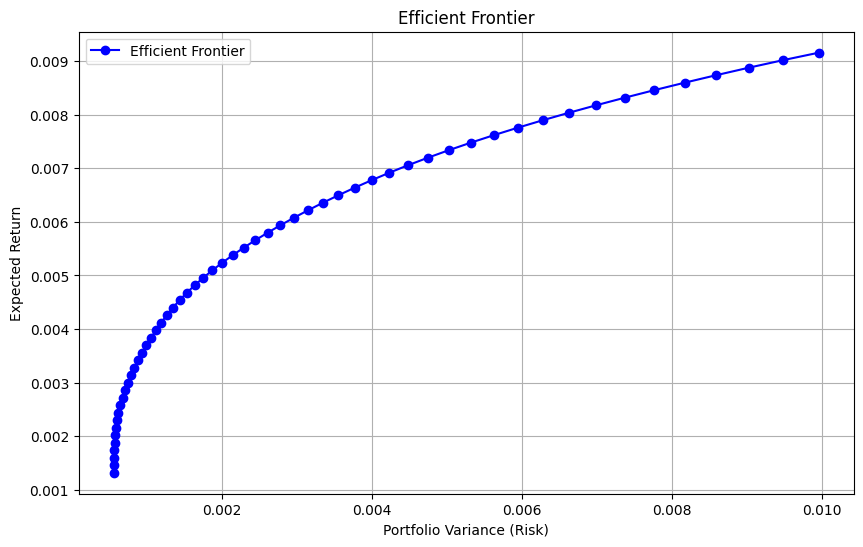

In [11]:
# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(filtered_frontier[:, 1], filtered_frontier[:, 0], 'b-o', label='Efficient Frontier')  # Efficient Frontier
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Variance (Risk)')
plt.ylabel('Expected Return')
plt.grid()
plt.legend()
plt.show()